In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
y_train = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
y_test = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
y_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [3]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


In [4]:
y_train.columns[1:]

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [5]:
sum(y_train.drop('image_id', axis=1).sum(axis=1) != 1)

0

On every row there is exactly one column that is 1 and all the other columns are 0.

In [6]:
y_train.tail()

,image_id,healthy,multiple_diseases,rust,scab
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0
1820,Train_1820,0,0,0,1


Image ids are named perfectly so we can use that.

In [7]:
from tensorflow.keras.preprocessing import image
X_train = [None]*1821

for i in range(1821):
    # /kaggle/input/plant-pathology-2020-fgvc7/images/Train_1524.jpg
    path = '/kaggle/input/plant-pathology-2020-fgvc7/images/Train_' + str(i) + '.jpg'
    img = image.load_img(path, grayscale=False, color_mode="rgb", target_size=(255,255), interpolation="nearest")
    img = image.img_to_array(img)
    X_train[i] = img
X_train = np.array(X_train)

In [8]:
y_train = y_train.drop('image_id', axis=1).to_numpy()

In [9]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(255,255,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(256, (4,4), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dropout(.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 253, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 256)       5

In [11]:
from tensorflow.keras.metrics import AUC
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[AUC()])
cb = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

In [12]:
model.fit(x=X_train, y=y_train, batch_size=128, epochs=500, callbacks=[cb], validation_split=0.25, verbose=2)

Epoch 1/500
11/11 - 15s - loss: 8.5722 - auc: 0.5667 - val_loss: 1.2823 - val_auc: 0.6921
Epoch 2/500
11/11 - 2s - loss: 1.3012 - auc: 0.6324 - val_loss: 1.2583 - val_auc: 0.6557
Epoch 3/500
11/11 - 2s - loss: 1.2764 - auc: 0.6414 - val_loss: 1.2625 - val_auc: 0.6416
Epoch 4/500
11/11 - 2s - loss: 1.2814 - auc: 0.6548 - val_loss: 1.2600 - val_auc: 0.6403
Epoch 5/500
11/11 - 2s - loss: 1.2609 - auc: 0.6504 - val_loss: 1.2414 - val_auc: 0.6774
Epoch 6/500
11/11 - 2s - loss: 1.2514 - auc: 0.6584 - val_loss: 1.2439 - val_auc: 0.6803
Epoch 7/500
11/11 - 2s - loss: 1.2487 - auc: 0.6771 - val_loss: 1.2268 - val_auc: 0.6905
Epoch 8/500
11/11 - 2s - loss: 1.2348 - auc: 0.6873 - val_loss: 1.2168 - val_auc: 0.6990
Epoch 9/500
11/11 - 2s - loss: 1.2295 - auc: 0.6943 - val_loss: 1.2318 - val_auc: 0.7040
Epoch 10/500
11/11 - 2s - loss: 1.2254 - auc: 0.6987 - val_loss: 1.2139 - val_auc: 0.7176
Epoch 11/500
11/11 - 2s - loss: 1.2194 - auc: 0.6988 - val_loss: 1.2006 - val_auc: 0.7199
Epoch 12/500
11/11

<AxesSubplot:>

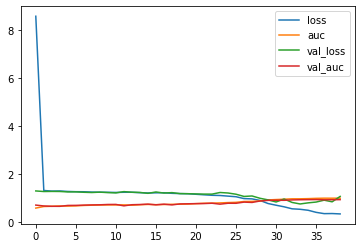

In [13]:
pd.DataFrame(model.history.history).plot()

In [14]:
X_test = [None]*1821

for i in range(1821):
    # /kaggle/input/plant-pathology-2020-fgvc7/images/Train_1524.jpg
    path = '/kaggle/input/plant-pathology-2020-fgvc7/images/Test_' + str(i) + '.jpg'
    img = image.load_img(path, grayscale=False, color_mode="rgb", target_size=(255,255), interpolation="nearest")
    img = image.img_to_array(img)
    X_test[i] = img
X_test = np.array(X_train)

In [15]:
pred = model.predict(X_test)

In [16]:
test_pred = pd.DataFrame(pred, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
result = pd.concat([y_test, test_pred], axis=1)
result.to_csv('plant_pathology_pred.csv',index=False)